In [6]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c dogs-vs-cats

In [ ]:
! mkdir train
! unzip train.zip -d train

In [12]:
! mkdir cats_and_dogs_small

! mkdir cats_and_dogs_small/train
! mkdir cats_and_dogs_small/validation
! mkdir cats_and_dogs_small/test

! mkdir cats_and_dogs_small/train/cats
! mkdir cats_and_dogs_small/validation/cats
! mkdir cats_and_dogs_small/test/cats

! mkdir cats_and_dogs_small/train/dogs
! mkdir cats_and_dogs_small/validation/dogs
! mkdir cats_and_dogs_small/test/dogs

In [13]:
import os, shutil

original_dataset_dir = '/content/train/train'
base_dir = '/content/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [14]:
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_cats_dir, fname)
  shutil.copyfile(src, dst)

In [15]:
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_cats_dir, fname)
  shutil.copyfile(src, dst)

In [16]:
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_cats_dir, fname)
  shutil.copyfile(src, dst)

In [17]:
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_dogs_dir, fname)
  shutil.copyfile(src, dst)

In [18]:
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]

for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_dogs_dir, fname)
  shutil.copyfile(src, dst)

In [19]:
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]

for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir, fname)
  shutil.copyfile(src, dst)

In [20]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [21]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [24]:
# Without Data Expansion (First way)

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=(4*4*512)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(learning_rate=2e-5), 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 8s 9ms/step - loss: 0.6962 - acc: 0.5946 - val_loss: 0.4689 - val_acc: 0.8260
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4869 - acc: 0.7585 - val_loss: 0.3829 - val_acc: 0.8510
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3766 - acc: 0.8363 - val_loss: 0.3358 - val_acc: 0.8790
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3172 - acc: 0.8730 - val_loss: 0.3094 - val_acc: 0.8840
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2866 - acc: 0.8936 - val_loss: 0.2885 - val_acc: 0.8910
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2762 - acc: 0.8913 - val_loss: 0.2768 - val_acc: 0.9000
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2378 - acc: 0.9010 - val_loss: 0.2732 - val_acc: 0.8880
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

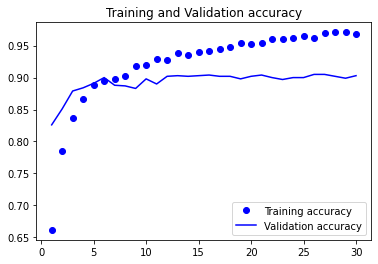

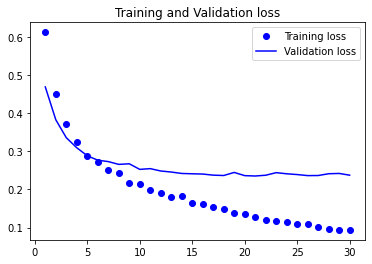

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [26]:
# With Data Expansion (Second way)

from keras.layers import Flatten

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [27]:
print('This is the number of trainable weights', 
      'before freezing the conv base',
      len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights', 
      'after freezing the conv base',
      len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base 30
This is the number of trainable weights after freezing the conv base 4


In [33]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [34]:
model.compile(optimizer=RMSprop(learning_rate=2e-5), 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 20s 190ms/step - loss: 0.3625 - acc: 0.8402 - val_loss: 0.2417 - val_acc: 0.9020
Epoch 2/30
100/100 [==============================] - 19s 191ms/step - loss: 0.3573 - acc: 0.8376 - val_loss: 0.2426 - val_acc: 0.9070
Epoch 3/30
100/100 [==============================] - 20s 198ms/step - loss: 0.3225 - acc: 0.8493 - val_loss: 0.2478 - val_acc: 0.8990
Epoch 4/30
100/100 [==============================] - 19s 189ms/step - loss: 0.3002 - acc: 0.8712 - val_loss: 0.2327 - val_acc: 0.9030
Epoch 5/30
100/100 [==============================] - 18s 184ms/step - loss: 0.3087 - acc: 0.8641 - val_loss: 0.2388 - val_acc: 0.9020
Epoch 6/30
100/100 [==============================] - 20s 199ms/step - loss: 0.3146 - acc: 0.8533 - val_loss: 0.2437 - val_acc: 0.8970
Epoch 7/30
100/100 [==============================] - 20s 196ms/step - loss: 0.3365 - acc: 0.8506 - val_loss: 0.2519 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 2

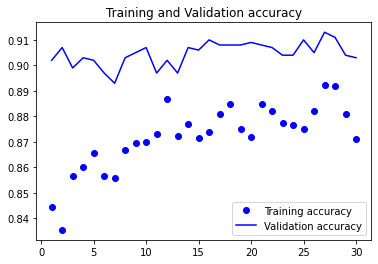

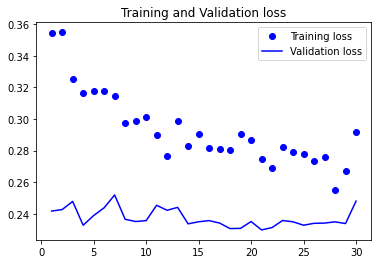

In [35]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [36]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [37]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [38]:
model.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(learning_rate=1e-5), 
              metrics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 24s 206ms/step - loss: 0.2869 - acc: 0.8697 - val_loss: 0.2199 - val_acc: 0.9160
Epoch 2/100
100/100 [==============================] - 19s 188ms/step - loss: 0.2504 - acc: 0.8937 - val_loss: 0.2282 - val_acc: 0.9070
Epoch 3/100
100/100 [==============================] - 19s 189ms/step - loss: 0.2513 - acc: 0.8861 - val_loss: 0.2003 - val_acc: 0.9210
Epoch 4/100
100/100 [==============================] - 20s 204ms/step - loss: 0.2165 - acc: 0.9078 - val_loss: 0.2586 - val_acc: 0.9060
Epoch 5/100
100/100 [==============================] - 19s 193ms/step - loss: 0.1984 - acc: 0.9170 - val_loss: 0.1884 - val_acc: 0.9330
Epoch 6/100
100/100 [==============================] - 19s 189ms/step - loss: 0.2117 - acc: 0.9153 - val_loss: 0.2034 - val_acc: 0.9230
Epoch 7/100
100/100 [==============================] - 20s 197ms/step - loss: 0.1877 - acc: 0.9307 - val_loss: 0.1923 - val_acc: 0.9270
Epoch 8/100
100/100 [===========================

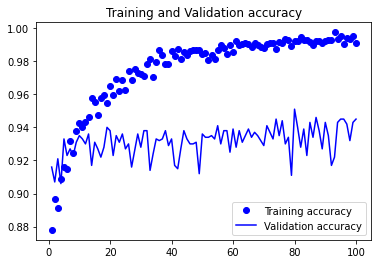

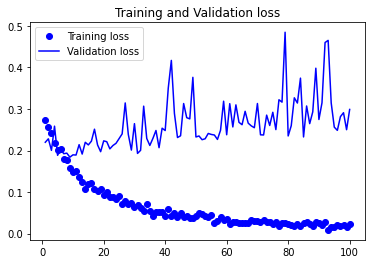

In [39]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [40]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

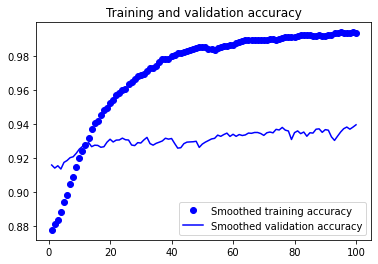

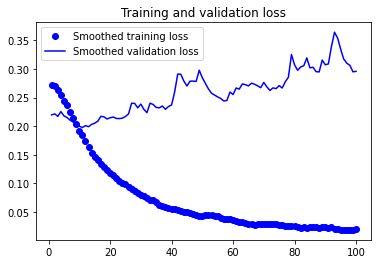

In [41]:
plt.plot(epochs, smooth_curve(acc),
         'bo', label='Smoothed training accuracy')
plt.plot(epochs, smooth_curve(val_acc),
         'b', label='Smoothed validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss),
         'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss),
         'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [42]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 3s 65ms/step - loss: 0.3347 - acc: 0.9410
test acc: 0.9409999847412109
